# IT-Skills for Research

In [22]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 20 16:18:28 2022

@author: angelDu @RB
"""
#%%
### Download necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import datetime 
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

# Specifying variables
path = r"C:\Users\angel\Final--crypto\data"
path= "/Users/julianfischer/projects/Final--crypto/data"


# Defining functions
def loadData(path):
    #cryptoPrices = pd.read_excel(path + '\CommonAssetClassesPrices.xlsx')
    equityPrices = pd.read_excel(path + '\Equities.xlsx')
    bondPrices = pd.read_excel(path + '\Bonds.xlsx')
    cmdtyPrices = pd.read_excel(path + '\Commodities.xlsx')
    vixPrices = pd.read_excel(path + '\VIX.xlsx')
    cryptoPrices = pd.read_excel(path + '\crypto-prices.xlsx')
    cryptoPrices['Dates'] = pd.to_datetime(cryptoPrices['Dates'])
    cryptoPrices.columns = ['Dates', 'BTC', 'ETH', 'XRP', 'XLM']
    
    return equityPrices, bondPrices, cmdtyPrices, vixPrices, cryptoPrices

def loadData_forcoolguys(path):
    #cryptoPrices = pd.read_excel(path + '\CommonAssetClassesPrices.xlsx')
    equityPrices = pd.read_excel(path + '/Equities.xlsx')
    bondPrices = pd.read_excel(path + '/Bonds.xlsx')
    cmdtyPrices = pd.read_excel(path + '/Commodities.xlsx')
    vixPrices = pd.read_excel(path + '/VIX.xlsx')
    cryptoPrices = pd.read_excel(path + '/crypto-prices.xlsx')
    cryptoPrices['Dates'] = pd.to_datetime(cryptoPrices['Dates'])
    cryptoPrices.columns = ['Dates', 'BTC', 'ETH', 'XRP', 'XLM']
    
    return equityPrices, bondPrices, cmdtyPrices, vixPrices, cryptoPrices

def getStartEnd(*data):
    minDate = datetime.datetime.strptime("30/11/0001","%d/%m/%Y")
    maxDate = datetime.datetime.strptime("30/11/3000","%d/%m/%Y")
    for d in data: 
        end = d['Dates'].iat[-1]
        start = d['Dates'][0]
        
        if end<maxDate:
            maxDate = end
            
        if start>minDate:
            minDate = start
            
    return minDate, maxDate
    
            
def makeDataUniformLength(start, end, assetList, *data):
    cnt = 0
    #aggData = []
    aggData = {}
    for d in data:
        d = d[(d['Dates']>=start)&(d['Dates']<=end)]
        #aggData.append([d])
        aggData[assetList[cnt]] = d
        cnt+=1
    
    return aggData

def mergeDataFrames(dictDf, assetList):
    merged = dictDf[assetList[0]]
    
    for i in range(len(assetList)):
        if i == len(assetList)-1:
            break
        merged = pd.merge(merged, dictDf[assetList[i+1]], on = ['Dates'])

    return merged 

def getBusinessDaysOnly(df):
    isBusinessDay = BDay().onOffset
    #isBusinessDay = BDay().is_on_offset()
    match_series = pd.to_datetime(df['Dates']).map(isBusinessDay)
    return df[match_series]

def calcDailyReturn(price):
    return price.pct_change(1)

def getCorr(df1,df2):
    corr, _ = pearsonr(df1, df2)
    return corr
    
    
#def plotRelationship(df1,df2):
# Importing data
assetNamesList = ['equity', 'bond', 'commodity', 'vix', 'crypto']
equity, bond, cmdty, vix, crypto = loadData_forcoolguys(path) 
#equity, bond, cmdty, vix, crypto = loadData(path) 
start, end = getStartEnd(equity, bond, cmdty, vix, crypto)
allData = makeDataUniformLength(start, end, assetNamesList, equity, bond, cmdty, vix, crypto)
mergedData = mergeDataFrames(allData, assetNamesList)


#weeklyData = mergedData.loc[mergedData.groupby(mergedData.index.to_period('W')).apply(lambda x: x.index.max())]



# Calculating returns
dailyRets = {}
for a in assetNamesList:
    dailyRets[a] = calcDailyReturn(allData[a].iloc[:,1:])

mergedDailyRets = calcDailyReturn(mergedData.iloc[:,1:])
mergedDailyRets.index = mergedData.Dates


# Specify different time periods
mergedDailyRets_Covid = mergedDailyRets.iloc[1071:1576,:]
mergedDailyRets_Covid_short = mergedDailyRets.iloc[1071:1324,:]
mergedDailyRets_Covid_today = mergedDailyRets.iloc[1071:,:]
mergedDailyRets_2022 = mergedDailyRets.iloc[1576:,:]

In [23]:
rets = mergedData.iloc[:,1:].pct_change(1)
dataProblem = mergedData.iloc[:19,7] 

for d in range(len(dataProblem.values)):
    if d == len(dataProblem.values)-1:
        break
    old = dataProblem.values[d]
    new = dataProblem.values[d+1]
    
    if (old<0 and new<0) or (old<0 and new>=0) or (old>0 and new<=0):
        rets.iloc[d+1,6] = 1 - new/old
        
    elif old == 0 and new == 0:
        rets.iloc[d+1,6] = 0
        
    elif old == 0 and new > 0:
        rets.iloc[d+1,6] = 1
        
    else:
        rets.iloc[d+1,6] = -1
        
mergedDailyRets.iloc[1:19,6] = rets.iloc[1:19,6] 

In [24]:
Index_names = mergedData.columns
Index_names


Index(['Dates', 'Hang Seng', 'NASDAQ', 'Stoxx 50', 'Nikkei', 'S&P500', 'GILTS',
       'US 3m Treasury', 'US 5YR Treasury', 'US 10YR Treasury', 'Euro 10y',
       'Japan 10y', 'Corn', 'Wheat', 'Coffee', 'Soybean', 'Cotton', 'Gold',
       'Silver', 'Copper', 'Platinum', 'Crude', 'Nat. gas', 'Liver cattle',
       'VIX Index', 'BTC', 'ETH', 'XRP', 'XLM'],
      dtype='object')

#### (mergedDailyRets["US 3m Treasury"])


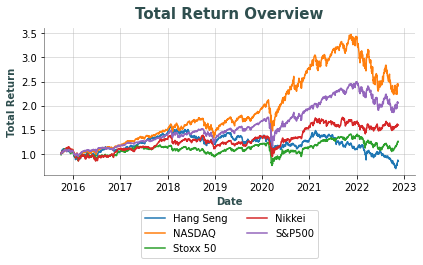

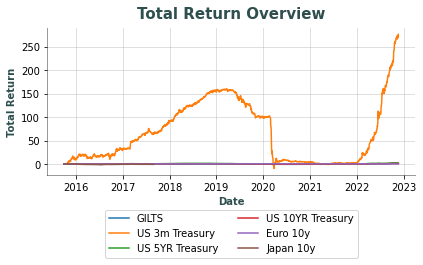

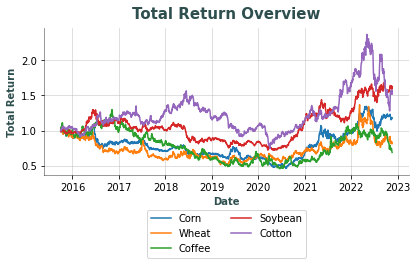

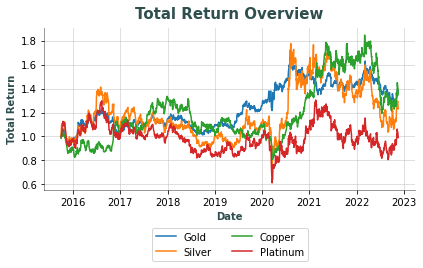

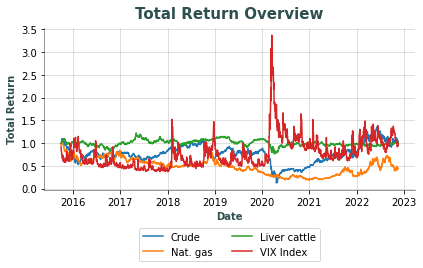

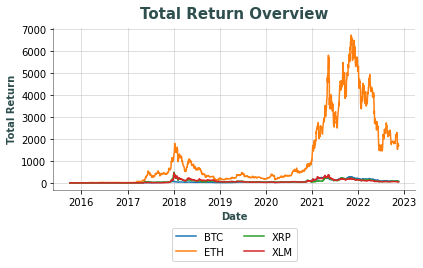

In [25]:
# EDA, plot some returns
totalRet = (mergedDailyRets+1).cumprod()
totalRet_Covid = (mergedDailyRets_Covid+1).cumprod()
totalRet_Covid_short = (mergedDailyRets_Covid_short+1).cumprod()
totalRet_Covid_today = (mergedDailyRets_Covid_today+1).cumprod()
totalRet_2022 = (mergedDailyRets_2022+1).cumprod()



#Plot them, Cryptos separately due to different scale
k=[1,6,12,17,21,25,len(Index_names)]
h=0
for j in range(len(k)-1):
    h+=1
    fig, ax = plt.subplots(1,1)
    for i in Index_names[k[h-1]:k[h]]:
        ax.plot(totalRet[i], label="{}".format(i))
        
    ax.set_xlabel("Date", fontweight="demi", c="darkslategray")
    ax.set_ylabel("Total Return", fontweight="demi", c="darkslategray")
    ax.set_title("Total Return Overview",fontsize=15, y=1.02, c="darkslategray", fontweight="bold")
    ax.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=2)
    #plt.xticks(rotation=70)
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.5)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.5) 
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    


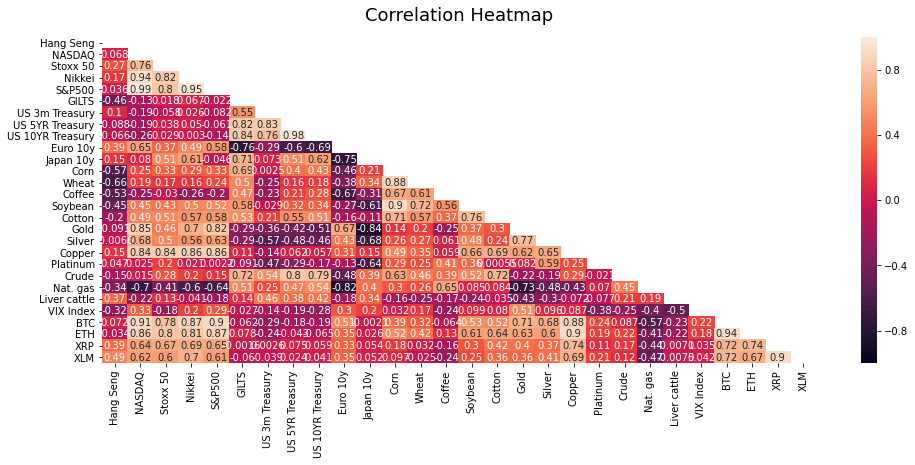

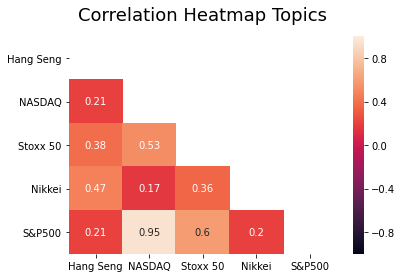

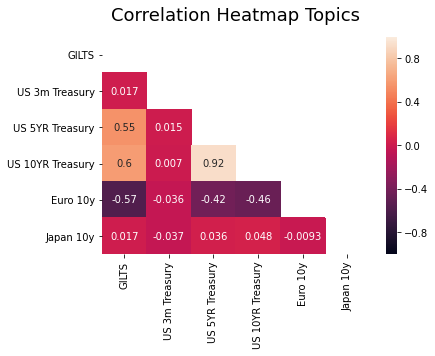

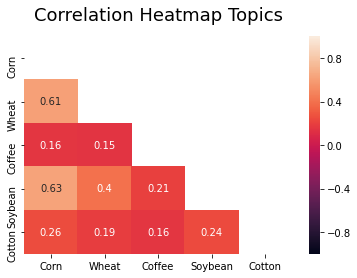

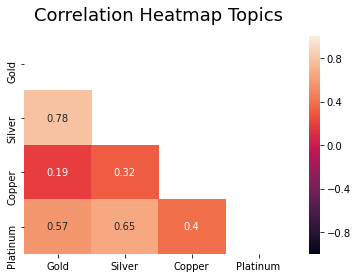

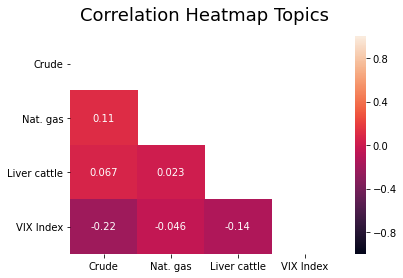

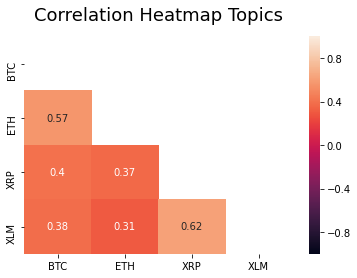

In [26]:
#Calc some correlations
import seaborn as sns
#sns.heatmap(totalRet.corr());

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(mergedDailyRets.corr(), dtype=np.bool))
heatmap = sns.heatmap(totalRet.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

k=[1,6,12,17,21,25,len(Index_names)]
h=0
for j in range(len(k)-1):
    h+=1
    fig, ax = plt.subplots(1,1)
    mask = np.triu(np.ones_like(mergedDailyRets[Index_names[k[h-1]:k[h]]].corr(), dtype=np.bool))
    heatmap = sns.heatmap(mergedDailyRets[Index_names[k[h-1]:k[h]]].corr(), mask=mask, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap Topics', fontdict={'fontsize':18}, pad=16)


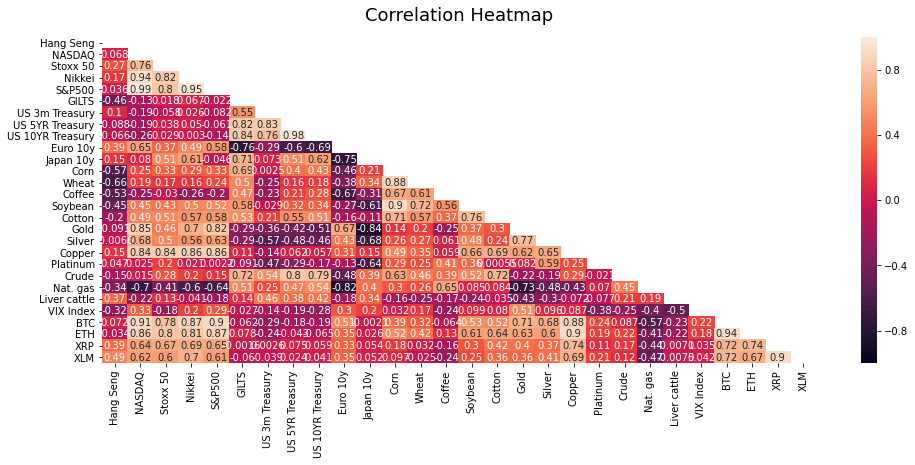

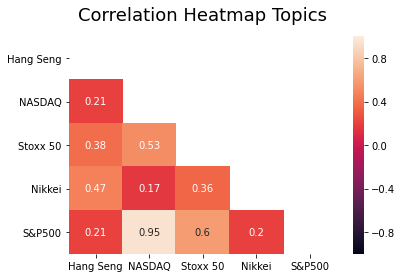

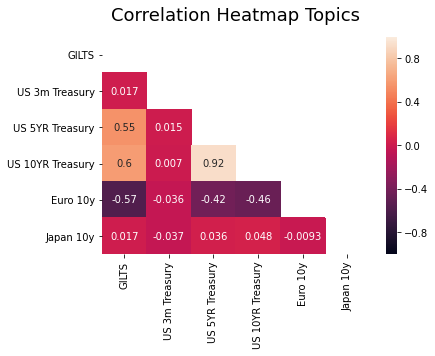

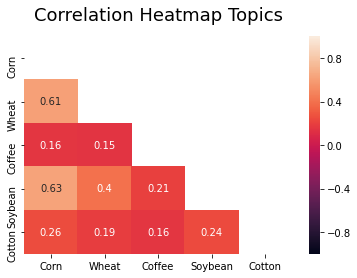

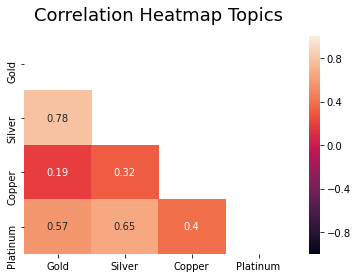

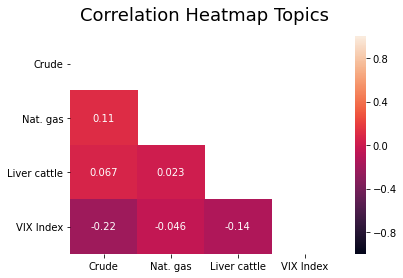

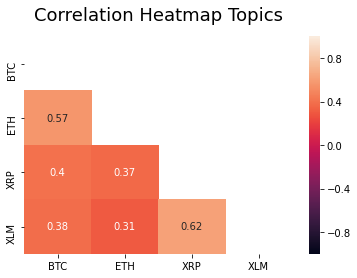

In [27]:
# Calculate some corr for Covid period



plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(mergedDailyRets.corr(), dtype=np.bool))
heatmap = sns.heatmap(totalRet.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

k=[1,6,12,17,21,25,len(Index_names)]
h=0
for j in range(len(k)-1):
    h+=1
    fig, ax = plt.subplots(1,1)
    mask = np.triu(np.ones_like(mergedDailyRets[Index_names[k[h-1]:k[h]]].corr(), dtype=np.bool))
    heatmap = sns.heatmap(mergedDailyRets[Index_names[k[h-1]:k[h]]].corr(), mask=mask, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap Topics', fontdict={'fontsize':18}, pad=16)



In [28]:
"""
Would be interesting to focus on NASDAQ for example and find the best hedging instrument --> Coffee?

or generally check what would work well.."""

'\nWould be interesting to focus on NASDAQ for example and find the best hedging instrument --> Coffee?\n\nor generally check what would work well..'

Table of p-values from the Granger Causality Test:
+---------------+-------+
| nasdaq_stoxx  | 0.034 |
| nasdaq_nikkei | 0.253 |
| vix_nasdaq    | 0.161 |
| nasdaq_coffee | 0.27  |
+---------------+-------+


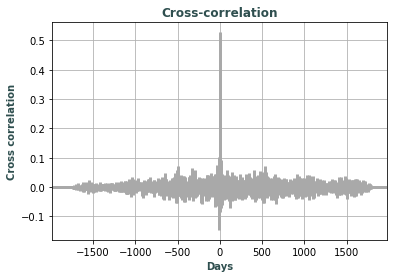

The maximal correlation is obtained 
  by shifting the index 0 days. (to the right if the number is positive.) 



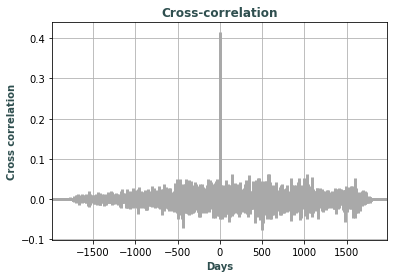

The maximal correlation is obtained 
  by shifting the index -1 days. (to the right if the number is positive.) 



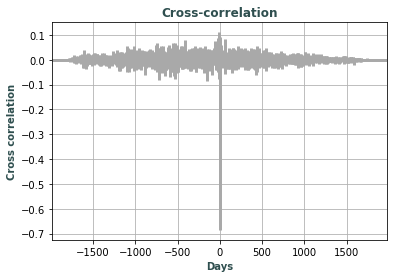

The maximal correlation is obtained 
  by shifting the index -8 days. (to the right if the number is positive.) 



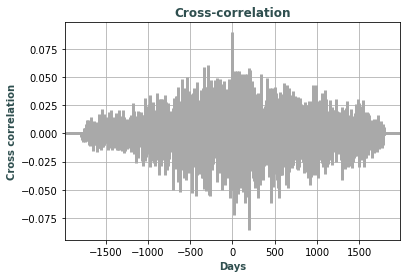

The maximal correlation is obtained 
  by shifting the index 0 days. (to the right if the number is positive.) 



In [29]:
from statsmodels.tsa.stattools import grangercausalitytests
from tabulate import tabulate
from scipy import signal

def get_grframe(grtest):
    #Returns a dataframe with the p-value of the ssr_chi2test
    grlist = []
    for i in range(1,maxlag):
        grlist.append(grtest[i][0]["ssr_chi2test"][1])
    grframe = pd.DataFrame(grlist, np.arange(1,maxlag), columns=['p-value'])
    grframe.index.name = "Number of lags"
    
    return grframe

maxlag= 30


# Create df according to requirements
df_nasdaq_stoxx = pd.DataFrame([mergedDailyRets["NASDAQ"],mergedDailyRets["Stoxx 50"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T
df_nasdaq_nikkei = pd.DataFrame([mergedDailyRets["NASDAQ"],mergedDailyRets["Nikkei"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T
df_vix_nasdaq = pd.DataFrame([mergedDailyRets["VIX Index"],mergedDailyRets["NASDAQ"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T
df_nasdaq_coffee = pd.DataFrame([mergedDailyRets["NASDAQ"],mergedDailyRets["Coffee"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T





# G-Testing
gtest_nasdaq_stoxx = grangercausalitytests(df_nasdaq_stoxx, maxlag, verbose=False)
gtest_nasdaq_nikkei = grangercausalitytests(df_nasdaq_nikkei, maxlag, verbose=False)
gtest_vix_nasdaq = grangercausalitytests(df_vix_nasdaq, maxlag, verbose=False)
gtest_nasdaq_coffee = grangercausalitytests(df_nasdaq_coffee, maxlag, verbose=False)



pvalues_gtest_nasdaq_stoxx = get_grframe(gtest_nasdaq_stoxx)
pvalues_gtest_nasdaq_nikkei = get_grframe(gtest_nasdaq_nikkei)
pvalues_gtest_vix_nasdaq = get_grframe(gtest_vix_nasdaq)
pvalues_gtest_nasdaq_coffee = get_grframe(gtest_nasdaq_coffee)


mean_pvalue_table = pd.DataFrame([np.mean(pvalues_gtest_nasdaq_stoxx),np.mean(pvalues_gtest_nasdaq_nikkei), np.mean(pvalues_gtest_vix_nasdaq), np.mean(pvalues_gtest_nasdaq_coffee)])
mean_pvalue_table.columns = ["Mean p-value"]
mean_pvalue_table.index = ["nasdaq_stoxx", "nasdaq_nikkei", "vix_nasdaq","nasdaq_coffee"]


print("Table of p-values from the Granger Causality Test:")
print(tabulate(round(mean_pvalue_table,3), tablefmt='psql'))

# the null hypothesis would be: X does not granger cause Y or the other way. Also, you accept or reject your null hypothesis depending on the level of significance.
# if P value < Significance level, then Null hypothesis would be rejected.
# if P value > Significance level, then Null hypothesis cannot be rejected.


def crosscorr_plot(data, a, col1, col2, new=False):
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    if new==True:
        ax1.xcorr(data[col1], data[col2], usevlines=True, maxlags=len(data[col1])-1,normed=True, lw=3, color="darkgrey")
        ax1.set_title("Cross-correlation",color="darkslategray",fontsize=12, fontweight="bold")
        temp = signal.correlate(data[col1], data[col2])
        shift = len(data[col1])-1

    else:
        
        ax1.xcorr(data[col1], data[col2], usevlines=True, maxlags=len(data[col1])-1,normed=True, lw=3, color="darkgrey")
        ax1.set_title("Cross-correlation",color="darkslategray",fontsize=12, fontweight="bold")
        temp = signal.correlate(data[col1], data[col2])
        shift = len(data[col1])-1

    ax1.grid(True)
    temp2 = int(np.where(temp == max(temp))[0])
    #or temp2 = np.argmax(temp)
    ax1.set_xlabel('Days',color="darkslategray",fontsize=10, fontweight="demi")
    ax1.set_ylabel('Cross correlation',color="darkslategray",fontsize=10, fontweight="demi")
    plt.show()
    print("The maximal correlation is obtained","\n"," by shifting the index",temp2-shift, "days. (to the right if the number is positive.)", "\n")
    return (temp2-shift)


lags_nasdaq_stoxx = crosscorr_plot(df_nasdaq_stoxx, 1, "NASDAQ", "Stoxx 50")
lags_nasdaq_nikkei = crosscorr_plot(df_nasdaq_nikkei, 1, "NASDAQ", "Nikkei")
lags_vix_nasdaq = crosscorr_plot(df_vix_nasdaq, 1, "VIX Index", "NASDAQ")
lags_vix_nasdaq = crosscorr_plot(df_nasdaq_coffee, 1, "NASDAQ", "Coffee")



In [30]:
"""hedge_nasdaq_with_coffee = (((mergedDailyRets["NASDAQ"]+mergedDailyRets["Coffee"])/2)+1).cumprod()
hedge_btc_with_soy_and_corn = (((mergedDailyRets["BTC"]+mergedDailyRets["Soybean"]+mergedDailyRets["Corn"])/3)+1).cumprod()
hedge_btc_with_natgas = (((mergedDailyRets["BTC"]+mergedDailyRets["Nat. gas"])/2)+1).cumprod()
"""

'hedge_nasdaq_with_coffee = (((mergedDailyRets["NASDAQ"]+mergedDailyRets["Coffee"])/2)+1).cumprod()\nhedge_btc_with_soy_and_corn = (((mergedDailyRets["BTC"]+mergedDailyRets["Soybean"]+mergedDailyRets["Corn"])/3)+1).cumprod()\nhedge_btc_with_natgas = (((mergedDailyRets["BTC"]+mergedDailyRets["Nat. gas"])/2)+1).cumprod()\n'

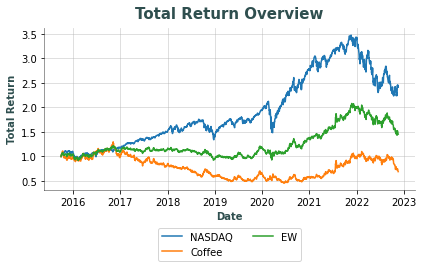

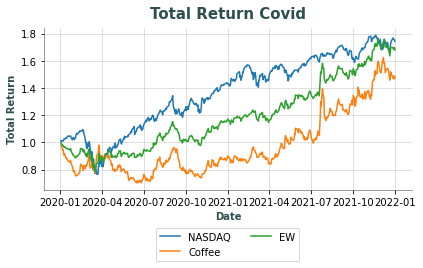

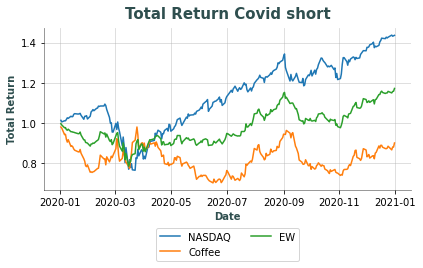

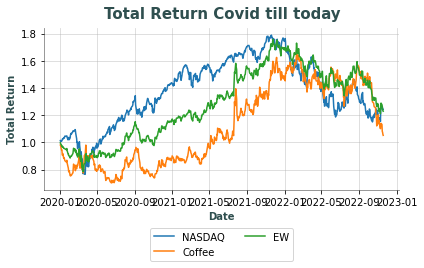

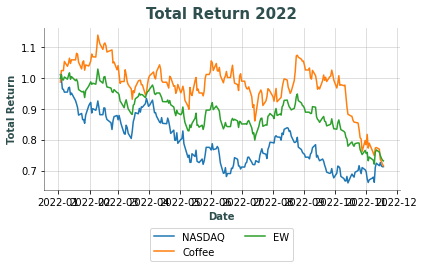

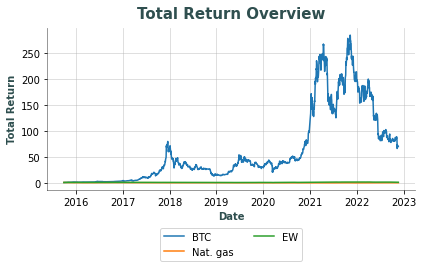

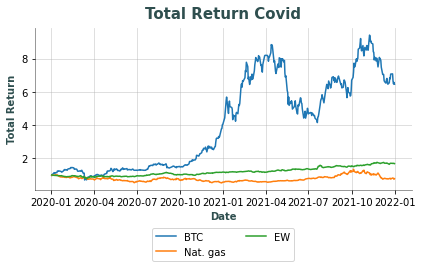

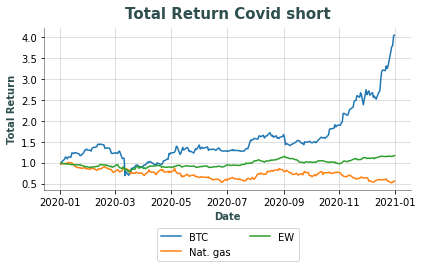

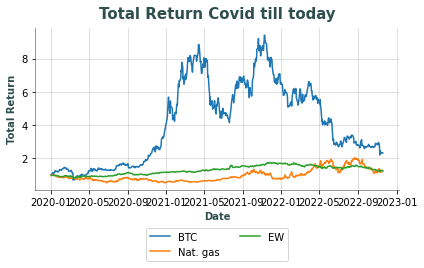

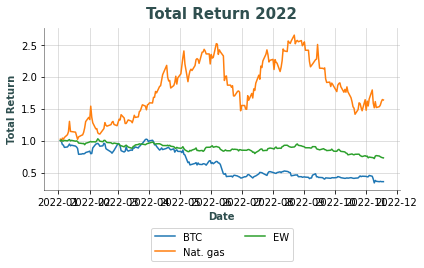

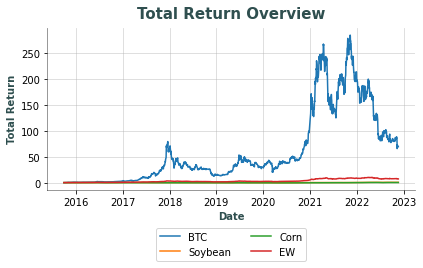

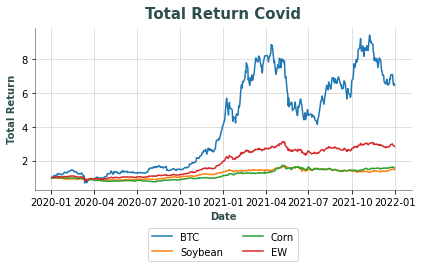

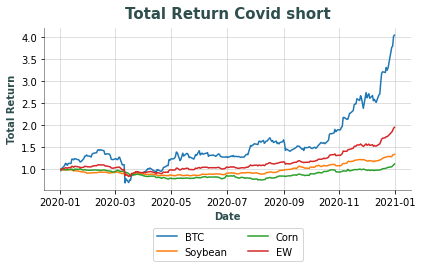

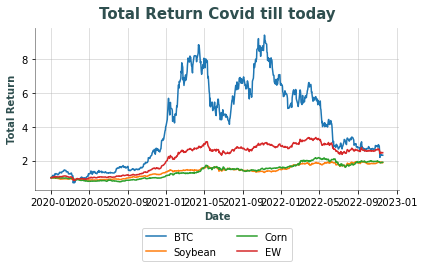

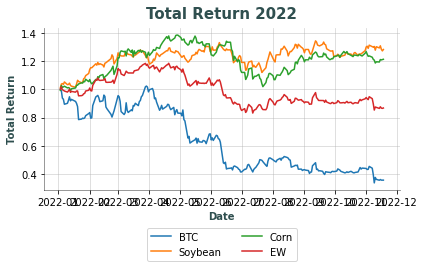

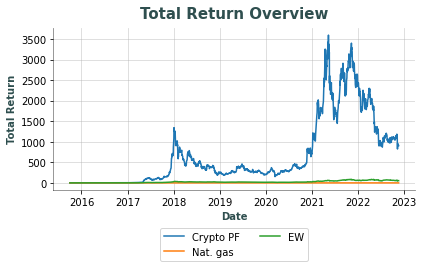

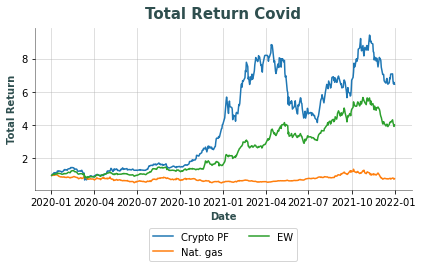

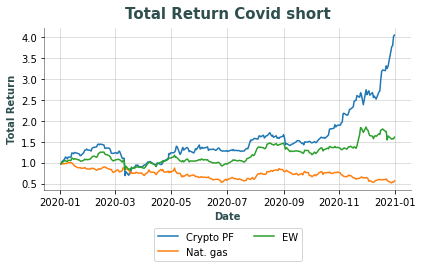

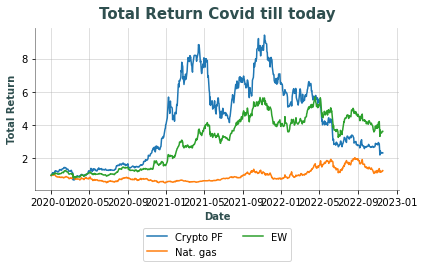

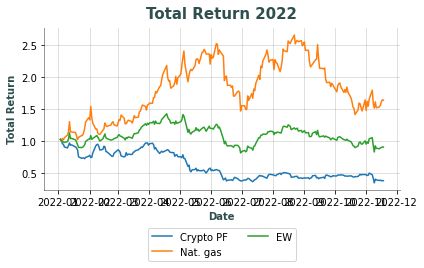

In [57]:
# Just wondering if coffee can hedge nasdaq (Covid and total time window)

# Create daily returns for portfolios for each period
DailyRets_Nasdaq_Coffee = ((mergedDailyRets["NASDAQ"]+mergedDailyRets["Coffee"])/2)
DailyRets_Nasdaq_Coffee_Covid = ((mergedDailyRets_Covid["NASDAQ"]+mergedDailyRets_Covid["Coffee"])/2)
DailyRets_Nasdaq_Coffee_Covid_short = ((mergedDailyRets_Covid_short["NASDAQ"]+mergedDailyRets_Covid_short["Coffee"])/2)
DailyRets_Nasdaq_Coffee_Covid_today = ((mergedDailyRets_Covid_today["NASDAQ"]+mergedDailyRets_Covid_today["Coffee"])/2)
DailyRets_Nasdaq_Coffee_2022 = (mergedDailyRets_2022["NASDAQ"]+mergedDailyRets_2022["Coffee"])/2

DailRets_BTC_NatGas = ((mergedDailyRets["BTC"]+mergedDailyRets["Nat. gas"])/2)
DailRets_BTC_NatGas_Covid = ((mergedDailyRets_Covid["BTC"]+mergedDailyRets_Covid["Nat. gas"])/2)
DailRets_BTC_NatGas_Covid_short = ((mergedDailyRets_Covid_short["BTC"]+mergedDailyRets_Covid_short["Nat. gas"])/2)
DailRets_BTC_NatGas_Covid_today = ((mergedDailyRets_Covid_today["BTC"]+mergedDailyRets_Covid_today["Nat. gas"])/2)
DailRets_BTC_NatGas_2022 = (mergedDailyRets_2022["BTC"]+mergedDailyRets_2022["Nat. gas"])/2

DailyRets_BTC_Soy_Corn = ((mergedDailyRets["BTC"]+mergedDailyRets["Soybean"]+mergedDailyRets["Corn"])/3)
DailyRets_BTC_Soy_Corn_Covid = ((mergedDailyRets_Covid["BTC"]+mergedDailyRets_Covid["Soybean"]+mergedDailyRets_Covid["Corn"])/3)
DailyRets_BTC_Soy_Corn_Covid_short = ((mergedDailyRets_Covid_short["BTC"]+mergedDailyRets_Covid_short["Soybean"]+mergedDailyRets_Covid_short["Corn"])/3)
DailyRets_BTC_Soy_Corn_Covid_today = ((mergedDailyRets_Covid_today["BTC"]+mergedDailyRets_Covid_today["Soybean"]+mergedDailyRets_Covid_today["Corn"])/3)
DailyRets_BTC_Soy_Corn_2022 = (mergedDailyRets_2022["BTC"]+mergedDailyRets_2022["Soybean"]+mergedDailyRets_2022["Corn"])/3

DailyRets_Crypto_pf = (mergedDailyRets["BTC"]+mergedDailyRets["ETH"]+mergedDailyRets["XRP"]+mergedDailyRets["XLM"])/4
DailyRets_Crypto_pf_Covid = (mergedDailyRets_Covid["BTC"]+mergedDailyRets_Covid["ETH"]+mergedDailyRets_Covid["XRP"]+mergedDailyRets_Covid["XLM"])/4
DailyRets_Crypto_pf_Covid_short = (mergedDailyRets_Covid_short["BTC"]+mergedDailyRets_Covid_short["ETH"]+mergedDailyRets_Covid_short["XRP"]+mergedDailyRets_Covid_short["XLM"])/4
DailyRets_Crypto_pf_Covid_today = (mergedDailyRets_Covid_today["BTC"]+mergedDailyRets_Covid_today["ETH"]+mergedDailyRets_Covid_today["XRP"]+mergedDailyRets_Covid_today["XLM"])/4
DailyRets_Crypto_pf_2022 = (mergedDailyRets_2022["BTC"]+mergedDailyRets_2022["ETH"]+mergedDailyRets_2022["XRP"]+mergedDailyRets_2022["XLM"])/4

DailyRets_Crypto_pf_Natgas = (DailyRets_Crypto_pf+mergedDailyRets["Nat. gas"])/2
DailyRets_Crypto_pf_Natgas_Covid = (DailyRets_Crypto_pf_Covid+mergedDailyRets_Covid["Nat. gas"])/2
DailyRets_Crypto_pf_Natgas_Covid_short = (DailyRets_Crypto_pf_Covid_short+mergedDailyRets_Covid_short["Nat. gas"])/2
DailyRets_Crypto_pf_Natgas_Covid_today = (DailyRets_Crypto_pf_Covid_today+mergedDailyRets_Covid_today["Nat. gas"])/2
DailyRets_Crypto_pf_Natgas_2022 = (DailyRets_Crypto_pf_2022+mergedDailyRets_2022["Nat. gas"])/2


# Calc total return for crypto pf
TotRet_Crypto_pf = (DailyRets_Crypto_pf+1).cumprod()
TotRet_Crypto_pf_Covid = (DailyRets_Crypto_pf_Covid+1).cumprod()
TotRet_Crypto_pf_Covid_short = (DailyRets_Crypto_pf_Covid_short+1).cumprod()
TotRet_Crypto_pf_Covid_today = (DailyRets_Crypto_pf_Covid_today+1).cumprod()
TotRet_Crypto_pf_2022 = (DailyRets_Crypto_pf_2022+1).cumprod()


# Calculate total return of the strategy
Strat_Nasdaq_Coffee = (DailyRets_Nasdaq_Coffee+1).cumprod()
Strat_Nasdaq_Coffee_Covid = (DailyRets_Nasdaq_Coffee_Covid+1).cumprod()
Strat_Nasdaq_Coffee_Covid_short = (DailyRets_Nasdaq_Coffee_Covid_short+1).cumprod()
Strat_Nasdaq_Coffee_Covid_today = (DailyRets_Nasdaq_Coffee_Covid_today+1).cumprod()
Strat_Nasdaq_Coffee_2022 =(DailyRets_Nasdaq_Coffee_2022+1).cumprod()

Strat_BTC_NatGas = (DailRets_BTC_NatGas+1).cumprod()
Strat_BTC_NatGas_Covid = (DailRets_BTC_NatGas_Covid+1).cumprod()
Strat_BTC_NatGas_Covid_short = (DailRets_BTC_NatGas_Covid_short+1).cumprod()
Strat_BTC_NatGas_Covid_today = (DailRets_BTC_NatGas_Covid_today+1).cumprod()
Strat_BTC_NatGas_2022 =(DailRets_BTC_NatGas_2022+1).cumprod()

Strat_BTC_Soy_Corn = (DailyRets_BTC_Soy_Corn+1).cumprod()
Strat_BTC_Soy_Corn_Covid = (DailyRets_BTC_Soy_Corn_Covid+1).cumprod()
Strat_BTC_Soy_Corn_Covid_short = (DailyRets_BTC_Soy_Corn_Covid_short+1).cumprod()
Strat_BTC_Soy_Corn_Covid_today = (DailyRets_BTC_Soy_Corn_Covid_today+1).cumprod()
Strat_BTC_Soy_Corn_2022 =(DailyRets_BTC_Soy_Corn_2022+1).cumprod()



Strat_Crypto_NatGas = (DailyRets_Crypto_pf_Natgas+1).cumprod()
Strat_Crypto_NatGas_Covid = (DailyRets_Crypto_pf_Natgas_Covid+1).cumprod()
Strat_Crypto_NatGas_Covid_short = (DailyRets_Crypto_pf_Natgas_Covid_short+1).cumprod()
Strat_Crypto_NatGas_Covid_today = (DailyRets_Crypto_pf_Natgas_Covid_today+1).cumprod()
Strat_Crypto_NatGas_2022 =(DailyRets_Crypto_pf_Natgas_2022+1).cumprod()



def plot_four(data1,data2,data3,data4,labels,ylabel,xlabel,title):
    fig, ax = plt.subplots(1,1)
    ax.plot(data1, label=labels[0])
    ax.plot(data2, label=labels[1])
    ax.plot(data3, label=labels[2])
    ax.plot(data4, label=labels[3])
    ax.set_xlabel(xlabel, fontweight="demi", c="darkslategray")
    ax.set_ylabel(ylabel, fontweight="demi", c="darkslategray")
    ax.set_title(title,fontsize=15, y=1.02, c="darkslategray", fontweight="bold")
    ax.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=2)
    #plt.xticks(rotation=70)
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.5)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.5) 
    plt.grid(True, alpha=0.5)
    plt.tight_layout()

def plot_three(data1,data2,data3,labels,ylabel,xlabel,title):
    fig, ax = plt.subplots(1,1)
    ax.plot(data1, label=labels[0])
    ax.plot(data2, label=labels[1])
    ax.plot(data3, label=labels[2])
    ax.set_xlabel(xlabel, fontweight="demi", c="darkslategray")
    ax.set_ylabel(ylabel, fontweight="demi", c="darkslategray")
    ax.set_title(title,fontsize=15, y=1.02, c="darkslategray", fontweight="bold")
    ax.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=2)
    #plt.xticks(rotation=70)
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.5)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.5) 
    plt.grid(True, alpha=0.5)
    plt.tight_layout()

plot_three(totalRet["NASDAQ"],totalRet["Coffee"],Strat_Nasdaq_Coffee,["NASDAQ","Coffee", "EW"],"Total Return","Date","Total Return Overview")
plot_three(totalRet_Covid["NASDAQ"],totalRet_Covid["Coffee"],Strat_Nasdaq_Coffee_Covid,["NASDAQ","Coffee", "EW"],"Total Return","Date","Total Return Covid")
plot_three(totalRet_Covid_short["NASDAQ"],totalRet_Covid_short["Coffee"],Strat_Nasdaq_Coffee_Covid_short,["NASDAQ","Coffee", "EW"],"Total Return","Date","Total Return Covid short")
plot_three(totalRet_Covid_today["NASDAQ"],totalRet_Covid_today["Coffee"],Strat_Nasdaq_Coffee_Covid_today,["NASDAQ","Coffee", "EW"],"Total Return","Date","Total Return Covid till today")
plot_three(totalRet_2022["NASDAQ"],totalRet_2022["Coffee"],Strat_Nasdaq_Coffee_2022,["NASDAQ","Coffee", "EW"],"Total Return","Date","Total Return 2022")


plot_three(totalRet["BTC"],totalRet["Nat. gas"],Strat_Nasdaq_Coffee,["BTC","Nat. gas", "EW"],"Total Return","Date","Total Return Overview")
plot_three(totalRet_Covid["BTC"],totalRet_Covid["Nat. gas"],Strat_Nasdaq_Coffee_Covid,["BTC","Nat. gas", "EW"],"Total Return","Date","Total Return Covid")
plot_three(totalRet_Covid_short["BTC"],totalRet_Covid_short["Nat. gas"],Strat_Nasdaq_Coffee_Covid_short,["BTC","Nat. gas", "EW"],"Total Return","Date","Total Return Covid short")
plot_three(totalRet_Covid_today["BTC"],totalRet_Covid_today["Nat. gas"],Strat_Nasdaq_Coffee_Covid_today,["BTC","Nat. gas", "EW"],"Total Return","Date","Total Return Covid till today")
plot_three(totalRet_2022["BTC"],totalRet_2022["Nat. gas"],Strat_Nasdaq_Coffee_2022,["BTC","Nat. gas", "EW"],"Total Return","Date","Total Return 2022")


plot_four(totalRet["BTC"],totalRet["Soybean"],totalRet["Corn"],Strat_BTC_Soy_Corn,["BTC","Soybean","Corn", "EW"],"Total Return","Date","Total Return Overview")
plot_four(totalRet_Covid["BTC"],totalRet_Covid["Soybean"],totalRet_Covid["Corn"],Strat_BTC_Soy_Corn_Covid,["BTC","Soybean","Corn", "EW"],"Total Return","Date","Total Return Covid")
plot_four(totalRet_Covid_short["BTC"],totalRet_Covid_short["Soybean"],totalRet_Covid_short["Corn"],Strat_BTC_Soy_Corn_Covid_short,["BTC","Soybean","Corn", "EW"],"Total Return","Date","Total Return Covid short")
plot_four(totalRet_Covid_today["BTC"],totalRet_Covid_today["Soybean"],totalRet_Covid_today["Corn"],Strat_BTC_Soy_Corn_Covid_today,["BTC","Soybean","Corn", "EW"],"Total Return","Date","Total Return Covid till today")
plot_four(totalRet_2022["BTC"],totalRet_2022["Soybean"],totalRet_2022["Corn"],Strat_BTC_Soy_Corn_2022,["BTC","Soybean","Corn", "EW"],"Total Return","Date","Total Return 2022")

plot_three(TotRet_Crypto_pf,totalRet["Nat. gas"],Strat_Crypto_NatGas,["Crypto PF","Nat. gas", "EW"],"Total Return","Date","Total Return Overview")
plot_three(totalRet_Covid["BTC"],totalRet_Covid["Nat. gas"],Strat_Crypto_NatGas_Covid,["Crypto PF","Nat. gas", "EW"],"Total Return","Date","Total Return Covid")
plot_three(totalRet_Covid_short["BTC"],totalRet_Covid_short["Nat. gas"],Strat_Crypto_NatGas_Covid_short,["Crypto PF","Nat. gas", "EW"],"Total Return","Date","Total Return Covid short")
plot_three(totalRet_Covid_today["BTC"],totalRet_Covid_today["Nat. gas"],Strat_Crypto_NatGas_Covid_today,["Crypto PF","Nat. gas", "EW"],"Total Return","Date","Total Return Covid till today")
plot_three(TotRet_Crypto_pf_2022,totalRet_2022["Nat. gas"],Strat_Crypto_NatGas_2022,["Crypto PF","Nat. gas", "EW"],"Total Return","Date","Total Return 2022")




In [114]:
# Define some metrics and compare portfolios according to these metrics!
"""Total Return
Sharpe Ratio
Skewness
Kurtosis
"""
def std_dev(data):
    # Get number of observations
    n = len(data)
    mean = sum(data) / n
    deviations = sum([(x - mean)**2 for x in data])
    variance = deviations / (n - 1)
    s = variance**(1/2)
    return s


def sharpe_ratio(data, risk_free_rate=0.0):
    mean_daily_return = sum(data) / len(data)
    s = std_dev(data)
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    # Annualize Daily Sharpe Ratio
    sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
    
    return sharpe_ratio


# Calculate Sharpe Ratio for given strategy/asset
SR_Nasdaq_Coffee_Covid_today = round(sharpe_ratio(DailyRets_Nasdaq_Coffee_Covid_today),3)
SR_Nasdaq_Coffee_2022 = round(sharpe_ratio(DailyRets_Nasdaq_Coffee_2022),3)

SR_BTC_NatGas_Covid_today = round(sharpe_ratio(DailRets_BTC_NatGas_Covid_today),3)
SR_BTC_NatGas_2022 = round(sharpe_ratio(DailRets_BTC_NatGas_2022),3)


SR_BTC_Soy_Corn_Covid_today = round(sharpe_ratio(DailyRets_BTC_Soy_Corn_Covid_today),3)
SR_BTC_Soy_Corn_2022 = round(sharpe_ratio(DailyRets_BTC_Soy_Corn_2022),3)

SR_crypto_Natgas_Covid_today = round(sharpe_ratio(DailyRets_Crypto_pf_Natgas_Covid_today),3)
SR_crypto_Natgas_2022 = round(sharpe_ratio(DailyRets_Crypto_pf_Natgas_2022),3)


SR_Nasdaq_Covid_today = round(sharpe_ratio(mergedDailyRets_Covid_today["NASDAQ"]),3)
SR_Nasdaq_2022 = round(sharpe_ratio(mergedDailyRets_2022["NASDAQ"]),3)

SR_BTC_Covid_today = round(sharpe_ratio(mergedDailyRets_Covid_today["BTC"]),3)
SR_BTC_2022 = round(sharpe_ratio(mergedDailyRets_2022["BTC"]),3)

SR_crypto_pf_Covid_today = round(sharpe_ratio(DailyRets_Crypto_pf_Covid_today),3)
SR_crypto_pf_2022 = round(sharpe_ratio(DailyRets_Crypto_pf_2022),3)



In [116]:
from scipy.stats import skew
from scipy.stats import kurtosis

# Calculate Skewness
Skew_Nasdaq_Coffee_Covid_today = round(skew(DailyRets_Nasdaq_Coffee_Covid_today),3)
Skew_Nasdaq_Coffee_2022 = round(skew(DailyRets_Nasdaq_Coffee_2022),3)

Skew_BTC_NatGas_Covid_today = round(skew(DailRets_BTC_NatGas_Covid_today),3)
Skew_BTC_NatGas_2022 = round(skew(DailRets_BTC_NatGas_2022),3)

Skew_BTC_Soy_Corn_Covid_today = round(skew(DailyRets_BTC_Soy_Corn_Covid_today),3)
Skew_BTC_Soy_Corn_2022 = round(skew(DailyRets_BTC_Soy_Corn_2022),3)

Skew_crypto_Natgas_Covid_today = round(skew(DailyRets_Crypto_pf_Natgas_Covid_today),3)
Skew_crypto_Natgas_2022 = round(skew(DailyRets_Crypto_pf_Natgas_2022),3)

Skew_Nasdaq_Covid_today = round(skew(mergedDailyRets_Covid_today["NASDAQ"]),3)
Skew_Nasdaq_2022 = round(skew(mergedDailyRets_2022["NASDAQ"]),3)

Skew_BTC_Covid_today = round(skew(mergedDailyRets_Covid_today["BTC"]),3)
Skew_BTC_2022 = round(skew(mergedDailyRets_2022["BTC"]),3)

Skew_crypto_pf_Covid_today = round(skew(DailyRets_Crypto_pf_Covid_today),3)
Skew_crypto_pf_2022 = round(skew(DailyRets_Crypto_pf_2022),3)


# Calculate Kurtosis
ExKurt_Nasdaq_Coffee_Covid_today = round(kurtosis(DailyRets_Nasdaq_Coffee_Covid_today)-3,3)
ExKurt_Nasdaq_Coffee_2022 = round(kurtosis(DailyRets_Nasdaq_Coffee_2022)-3,3)

ExKurt_BTC_NatGas_Covid_today = round(kurtosis(DailRets_BTC_NatGas_Covid_today)-3,3)
ExKurt_BTC_NatGas_2022 = round(kurtosis(DailRets_BTC_NatGas_2022)-3,3)

ExKurt_BTC_Soy_Corn_Covid_today = round(kurtosis(DailyRets_BTC_Soy_Corn_Covid_today)-3,3)
ExKurt_BTC_Soy_Corn_2022 = round(kurtosis(DailyRets_BTC_Soy_Corn_2022)-3,3)

ExKurt_crypto_Natgas_Covid_today = round(kurtosis(DailyRets_Crypto_pf_Natgas_Covid_today)-3,3)
ExKurt_crypto_Natgas_2022 = round(kurtosis(DailyRets_Crypto_pf_Natgas_2022)-3,3)

ExKurt_Nasdaq_Covid_today = round(kurtosis(mergedDailyRets_Covid_today["NASDAQ"])-3,3)
ExKurt_Nasdaq_2022 = round(kurtosis(mergedDailyRets_2022["NASDAQ"])-3,3)

ExKurt_BTC_Covid_today = round(kurtosis(mergedDailyRets_Covid_today["BTC"])-3,3)
ExKurt_BTC_2022 = round(kurtosis(mergedDailyRets_2022["BTC"])-3,3)

ExKurt_crypto_pf_Covid_today = round(kurtosis(DailyRets_Crypto_pf_Covid_today)-3,3)
ExKurt_crypto_pf_2022 = round(kurtosis(DailyRets_Crypto_pf_2022)-3,3)


# Calculate mean return
MeanRet_Nasdaq_Coffee_Covid_today = round(np.mean(DailyRets_Nasdaq_Coffee_Covid_today),4)
MeanRet_Nasdaq_Coffee_2022 = round(np.mean(DailyRets_Nasdaq_Coffee_2022),4)

MeanRet_BTC_NatGas_Covid_today = round(np.mean(DailRets_BTC_NatGas_Covid_today),4)
MeanRet_BTC_NatGas_2022 = round(np.mean(DailRets_BTC_NatGas_2022),4)

MeanRet_BTC_Soy_Corn_Covid_today = round(np.mean(DailyRets_BTC_Soy_Corn_Covid_today),4)
MeanRet_BTC_Soy_Corn_2022 = round(np.mean(DailyRets_BTC_Soy_Corn_2022),4)

MeanRet_crypto_Natgas_Covid_today = round(np.mean(DailyRets_Crypto_pf_Natgas_Covid_today),4)
MeanRet_crypto_Natgas_2022 = round(np.mean(DailyRets_Crypto_pf_Natgas_2022),4)

MeanRet_Nasdaq_Covid_today = round(np.mean(mergedDailyRets_Covid_today["NASDAQ"]),3)
MeanRet_Nasdaq_2022 = round(np.mean(mergedDailyRets_2022["NASDAQ"]),3)

MeanRet_BTC_Covid_today = round(np.mean(mergedDailyRets_Covid_today["BTC"]),3)
MeanRet_BTC_2022 = round(np.mean(mergedDailyRets_2022["BTC"]),3)

MeanRet_crypto_pf_Covid_today = round(np.mean(DailyRets_Crypto_pf_Covid_today),3)
MeanRet_crypto_pf_2022 = round(np.mean(DailyRets_Crypto_pf_2022),3)



In [118]:
# Create and plot a table
table_data_Covid_today = pd.DataFrame([["","Mean Return","Sharpe Ratio","Skewness","Kurtosis"],
             ["NASDAQ",MeanRet_Nasdaq_Covid_today,SR_Nasdaq_Covid_today,Skew_Nasdaq_Covid_today,ExKurt_Nasdaq_Covid_today],
             ["NASDAQ/Coffee",MeanRet_Nasdaq_Coffee_Covid_today,SR_Nasdaq_Coffee_Covid_today,Skew_Nasdaq_Coffee_Covid_today,ExKurt_Nasdaq_Coffee_Covid_today],
             ["BTC",MeanRet_BTC_Covid_today,SR_BTC_Covid_today,Skew_BTC_Covid_today,ExKurt_BTC_Covid_today],
             ["BTC/Nat. gas",MeanRet_BTC_NatGas_Covid_today,SR_BTC_NatGas_Covid_today,Skew_BTC_NatGas_Covid_today,ExKurt_BTC_NatGas_Covid_today],
             ["BTC/Soybean&Corn",MeanRet_BTC_Soy_Corn_Covid_today,SR_BTC_Soy_Corn_Covid_today,Skew_BTC_Soy_Corn_Covid_today,ExKurt_BTC_Soy_Corn_Covid_today],
             ["Crypto PF",MeanRet_crypto_pf_Covid_today,SR_crypto_pf_Covid_today,Skew_crypto_pf_Covid_today,ExKurt_crypto_pf_Covid_today],
             ["Crypto PF/Nat. gas",MeanRet_crypto_Natgas_Covid_today,SR_crypto_Natgas_Covid_today,Skew_crypto_Natgas_Covid_today,ExKurt_crypto_Natgas_Covid_today]])
table_data_Covid_today.set_index(table_data_Covid_today.iloc[:,0].values, inplace=True)
table_data_Covid_today.drop(table_data_Covid_today.columns[0],axis = 1, inplace=True)


table_data_2022 = pd.DataFrame([["","Mean Return","Sharpe Ratio","Skewness","Kurtosis"],
             ["NASDAQ",MeanRet_Nasdaq_2022,SR_Nasdaq_2022,Skew_Nasdaq_2022,ExKurt_Nasdaq_2022],
             ["NASDAQ/Coffee",MeanRet_Nasdaq_Coffee_2022,SR_Nasdaq_Coffee_2022,Skew_Nasdaq_Coffee_2022,ExKurt_Nasdaq_Coffee_2022],
             ["BTC",MeanRet_BTC_2022,SR_BTC_2022,Skew_BTC_2022,ExKurt_BTC_2022],
             ["BTC/Nat. gas",MeanRet_BTC_NatGas_2022,SR_BTC_NatGas_2022,Skew_BTC_NatGas_2022,ExKurt_BTC_NatGas_2022],
             ["BTC/Soybean&Corn",MeanRet_BTC_Soy_Corn_2022,SR_BTC_Soy_Corn_2022,Skew_BTC_Soy_Corn_2022,ExKurt_BTC_Soy_Corn_2022],
             ["Crypto PF",MeanRet_crypto_pf_2022,SR_crypto_pf_2022,Skew_crypto_pf_2022,ExKurt_crypto_pf_2022],
             ["Crypto PF/Nat. gas",MeanRet_crypto_Natgas_2022,SR_crypto_Natgas_2022,Skew_crypto_Natgas_2022,ExKurt_crypto_Natgas_2022]])
table_data_2022.set_index(table_data_2022.iloc[:,0].values, inplace=True)
table_data_2022.drop(table_data_2022.columns[0],axis = 1, inplace=True)


print(tabulate(table_data_Covid_today,headers='firstrow',tablefmt='fancy_grid'))
print(tabulate(table_data_2022,headers='firstrow',tablefmt='fancy_grid'))





╒════════════════════╤═══════════════╤════════════════╤════════════╤════════════╕
│                    │   Mean Return │   Sharpe Ratio │   Skewness │   Kurtosis │
╞════════════════════╪═══════════════╪════════════════╪════════════╪════════════╡
│ NASDAQ             │        0      │          0.401 │     -0.42  │      2.297 │
├────────────────────┼───────────────┼────────────────┼────────────┼────────────┤
│ NASDAQ/Coffee      │        0.0004 │          0.416 │     -0.129 │     -1.092 │
├────────────────────┼───────────────┼────────────────┼────────────┼────────────┤
│ BTC                │        0.002  │          0.776 │     -0.775 │      5.213 │
├────────────────────┼───────────────┼────────────────┼────────────┼────────────┤
│ BTC/Nat. gas       │        0.0017 │          0.869 │     -0.498 │      0.42  │
├────────────────────┼───────────────┼────────────────┼────────────┼────────────┤
│ BTC/Soybean&Corn   │        0.0014 │          1.21  │     -0.652 │      2.864 │
├───────────────